# **Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий**

### Цель: изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.





# **Начало работы. Чтение журнала событий**

Библиотека pm4py работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:

-converter из pm4py.objects.conversion.log (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий;
-importer из pm4py.objects.log.importer.xes (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.
Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки pm4py.objects.conversion.log.converter преобразуем его в журнал событий.

In [144]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [146]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [147]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [148]:
type(log_csv)

pandas.core.frame.DataFrame

In [149]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [150]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [151]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [152]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [153]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [154]:
import seaborn as sns

<Axes: xlabel='relativetime_s', ylabel='patient'>

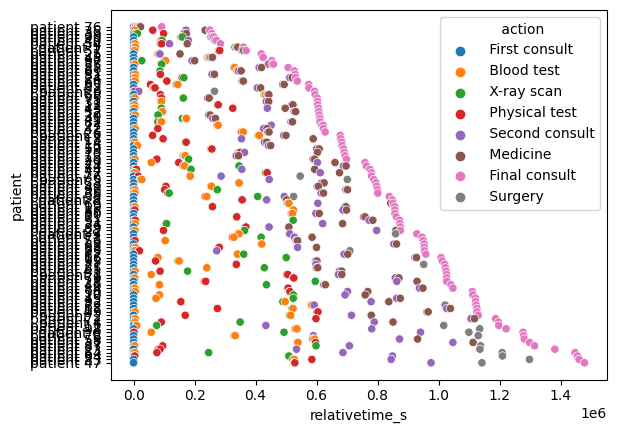

In [155]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [156]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [157]:
len(log_csv['patient'].unique())

100

In [158]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

In [159]:
import matplotlib.pyplot as plt

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

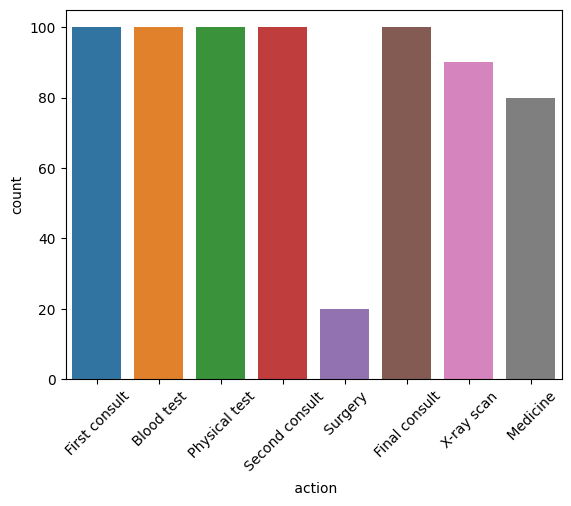

In [160]:
sns.countplot(x=log_csv[' action'])
plt.xticks(rotation=45)

In [161]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:

Идентификатор случая (case id): хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
Деятельность (activity name): хранит действия, выполняемые в рамках событий журнала.
Отметка времени (timestamp): хранит дату и время регистрации событий журнала.
Ресурс (resource): хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
Прочее (other data): сюда попадает вся оставшаяся в журнале (не интересная нам) информация.
В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [162]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [163]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [164]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [165]:
log_csv.shape

(690, 10)

In [166]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [167]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [168]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [169]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [170]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [171]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [172]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

### **Построение модели по журналу событий**

# **Alpha Miner**

In [173]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

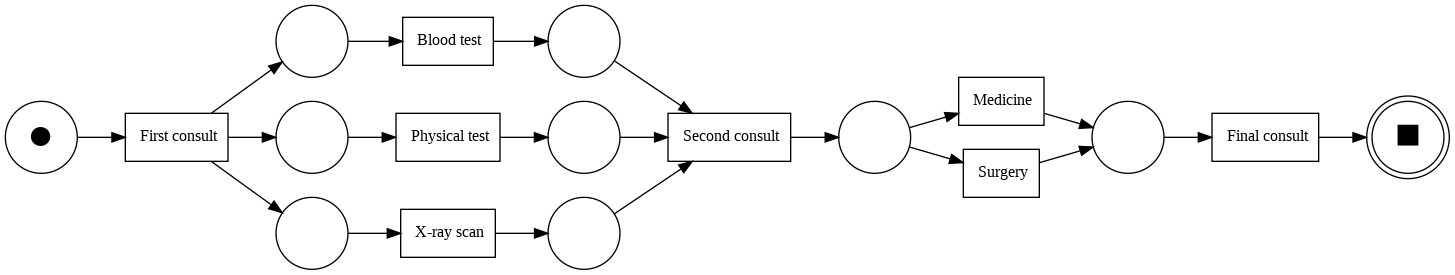

In [174]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

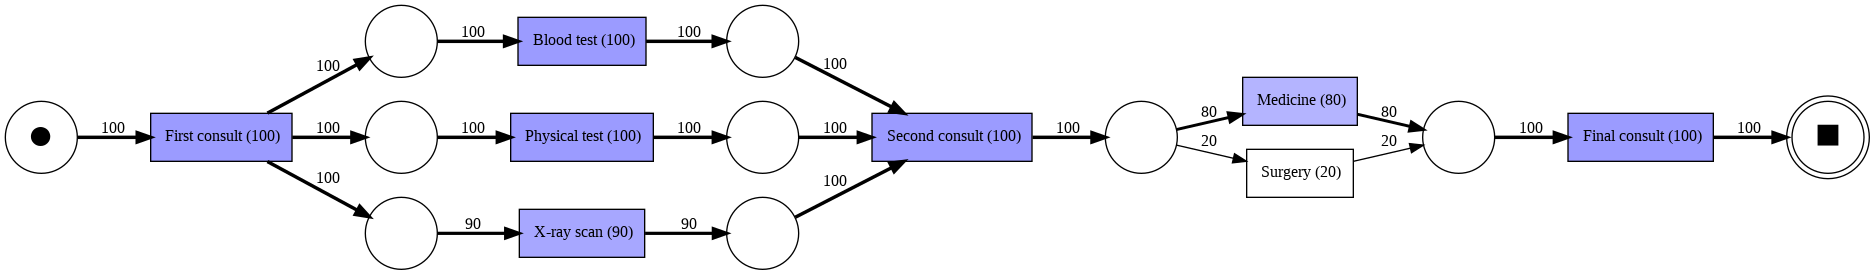

In [175]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [176]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция get_transition_performance_with_token_replay принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [177]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [178]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( Second consult, ' Second consult')", "( Medicine, ' Medicine')", "( Surgery, ' Surgery')", "( Final consult, ' Final consult')"])

In [179]:
log_csv[log_csv['case:concept:name'] == 'patient 13']


,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

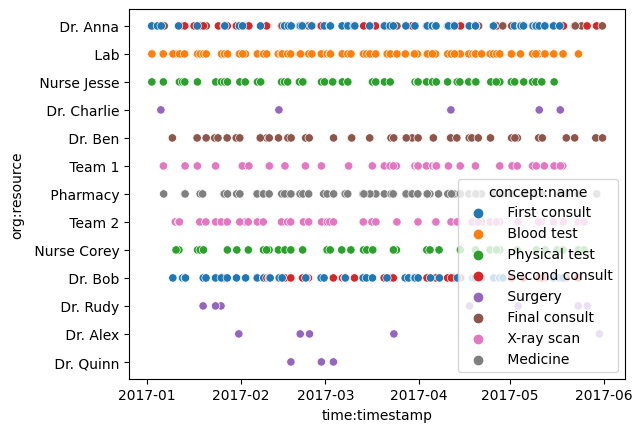

In [180]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

**Среднее время операции**: 4 дней
**Максимальное время операции**: 7 days
**Минимальное время операции**: 0 days, i.e. 8.469 hours


<ipython-input-181-519b8342d55c>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(surgery_time)


<Axes: ylabel='Density'>

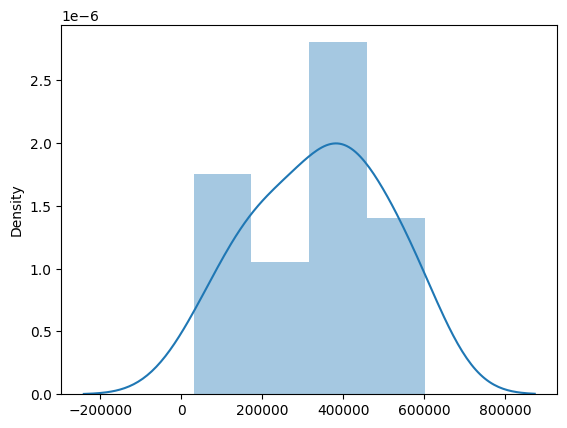

In [181]:
import numpy as np
import seaborn as sns

surgery_time = traces["( Surgery, ' Surgery')"]['all_values']
seconds_to_days = 60*60*24
seconds_to_hours = 60*60
print('**Среднее время операции**: {:.0f} дней'.format(np.mean(surgery_time)/seconds_to_days))
print('**Максимальное время операции**: {:.0f} days'.format(np.max(surgery_time)/seconds_to_days))
print('**Минимальное время операции**: {:.0f} days, i.e. {:.3f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
sns.distplot(surgery_time)

# **Задания. Изучение журнала событий**

1.Каково минимальное и максимальное количество событий в одном случае?

2.Какие события являются общими для всех процессов?

3.Найдите наибоее часто встречающуюся последовательность событий.

4.Какой пациент на лечение тратил меньше всего времени, а какой больше?

5.Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

6.Pation 13 с каким врачом/врачами он/она консультировался?

7.Какое событие является наиболее ресурсоёмким в данном журнале событий?

8.Есть ли врачи или медсестры, которые перегружены работой?

9.Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

10.Какие события связаны с узкими местами и какие ресурсы задействованы?

11.Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

12.Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.

1. Минимальное количество событий

In [182]:
concept_grouped = log_csv.groupby('case:concept:name').count()['concept:name']
concept_grouped

case:concept:name
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Name: concept:name, Length: 100, dtype: int64

In [183]:
print("Минимальное количество событий ", min(log_csv.groupby('case:concept:name').count()['concept:name']))

Минимальное количество событий  6


2. Какие события являются общими для всех процессов?

In [184]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activ = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activ

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Общими являются те, возле которых стоит цифра 100, то есть: 



 
 
 

In [185]:
set.intersection(*[set(x['variant']) for x in variants_count])

{' Blood test',
 ' Final consult',
 ' First consult',
 ' Physical test',
 ' Second consult'}

3. Найдите наибоее часто встречающуюся последовательность событий.

In [186]:
top = case_statistics.get_variant_statistics(log_csv)[0]
top

{'variant': (' First consult',
  ' Blood test',
  ' X-ray scan',
  ' Physical test',
  ' Second consult',
  ' Medicine',
  ' Final consult'),
 'count': 18}

4. Какой пациент на лечение тратил меньше всего времени, а какой больше?

In [187]:
print("Наибольшее:") 
print(log_csv[log_csv['caselength'] == log_csv['caselength'].max()]) 


Наибольшее:
    case:concept:name     concept:name  org:resource      time:timestamp  \
321        patient 47    First consult      Dr. Anna 2017-03-10 09:27:44   
322        patient 47       X-ray scan        Team 1 2017-03-16 11:37:27   
323        patient 47       Blood test           Lab 2017-03-16 11:56:43   
324        patient 47    Physical test   Nurse Jesse 2017-03-16 12:21:37   
325        patient 47   Second consult      Dr. Anna 2017-03-21 16:24:41   
326        patient 47          Surgery      Dr. Alex 2017-03-23 14:44:57   
327        patient 47    Final consult      Dr. Anna 2017-03-27 12:10:48   

                caseend           casestart     relativetime  relativetime_s  \
321 2017-03-27 12:10:48 2017-03-10 09:27:44  0 days 00:00:00               0   
322 2017-03-27 12:10:48 2017-03-10 09:27:44  6 days 02:09:43          526183   
323 2017-03-27 12:10:48 2017-03-10 09:27:44  6 days 02:28:59          527339   
324 2017-03-27 12:10:48 2017-03-10 09:27:44  6 days 02:53:5

In [188]:
print("Наименьшее:") 
print(log_csv[log_csv['caselength'] == log_csv['caselength'].min()])

Наименьшее:
    case:concept:name     concept:name  org:resource      time:timestamp  \
523        patient 76    First consult       Dr. Bob 2017-04-19 10:52:43   
524        patient 76       Blood test           Lab 2017-04-19 12:21:40   
525        patient 76       X-ray scan        Team 1 2017-04-19 14:05:24   
526        patient 76    Physical test   Nurse Corey 2017-04-19 14:40:28   
527        patient 76   Second consult      Dr. Anna 2017-04-19 15:59:10   
528        patient 76         Medicine      Pharmacy 2017-04-19 17:14:14   
529        patient 76    Final consult       Dr. Ben 2017-04-20 12:26:47   

                caseend           casestart    relativetime  relativetime_s  \
523 2017-04-20 12:26:47 2017-04-19 10:52:43 0 days 00:00:00               0   
524 2017-04-20 12:26:47 2017-04-19 10:52:43 0 days 01:28:57            5337   
525 2017-04-20 12:26:47 2017-04-19 10:52:43 0 days 03:12:41           11561   
526 2017-04-20 12:26:47 2017-04-19 10:52:43 0 days 03:47:45    

5. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

In [189]:
tmp = log_csv['case:concept:name'].value_counts().reset_index()
tmp.columns = ['case:concept:name', 'NumActions']
log_csv = pd.merge(log_csv, tmp, on='case:concept:name')
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,6
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,6
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,6
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,6
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,6
...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,7
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,7
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,7
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,7


In [190]:
log_csv['NumOfAct'] = log_csv.groupby('case:concept:name').cumcount() + 1

6. Pation 13 с каким врачом/врачами он/она консультировался?

In [191]:
print(f"Patient 13 консультировался с врачами: {log_csv[log_csv['case:concept:name'] == 'patient 13']['org:resource'].values}")

Patient 13 консультировался с врачами: [' Dr. Bob' ' Team 2' ' Nurse Jesse' ' Lab' ' Dr. Anna' ' Pharmacy'
 ' Dr. Ben']


In [192]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions,NumOfAct
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34,7,1
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34,7,2
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34,7,3
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34,7,4
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34,7,5
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34,7,6
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34,7,7


7. Какое событие является наиболее ресурсоёмким в данном журнале событий?

In [193]:
import numpy as np

log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby('case:concept:name')['diff'].shift(-1)
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv, index=["concept:name"], values = 'time', aggfunc=['sum', 'min', 'mean', 'max'])

,sum,min,mean,max
,time,time,time,time
concept:name,,,,
Blood test,201 days 09:17:03,0 days 00:01:30,2 days 00:19:58.230000,6 days 21:49:43
Final consult,0 days 00:00:00,NaT,NaT,NaT
First consult,154 days 16:10:24,0 days 00:22:04,1 days 13:07:18.240000,6 days 19:05:18
Medicine,171 days 03:07:31,0 days 01:14:29,2 days 03:20:20.637500,4 days 20:12:25
Physical test,169 days 16:55:56,0 days 00:02:11,1 days 16:43:45.560000,6 days 00:14:46
Second consult,108 days 19:51:08,0 days 01:01:30,1 days 02:07:06.680000,6 days 23:07:53
Surgery,40 days 00:41:02,0 days 01:12:33,2 days 00:02:03.100000,3 days 21:25:51
X-ray scan,111 days 22:51:00,0 days 00:00:38,1 days 05:51:14,5 days 22:08:37


Самым длительным процессом является Blood test


8. Есть ли врачи или медсестры, которые перегружены работой?

In [194]:
activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [195]:

pd.pivot_table(log_csv, index=["concept:name", "org:resource"], values = 'time', aggfunc=['sum'])

sum
                                          time
concept:name    org:resource                  
 Blood test      Lab         201 days 09:17:03
 Final consult   Dr. Anna      0 days 00:00:00
                 Dr. Ben       0 days 00:00:00
 First consult   Dr. Anna     69 days 07:46:45
                 Dr. Bob      85 days 08:23:39
 Medicine        Pharmacy    171 days 03:07:31
 Physical test   Nurse Corey  76 days 13:52:01
                 Nurse Jesse  93 days 03:03:55
 Second consult  Dr. Anna     57 days 17:50:57
                 Dr. Bob      51 days 02:00:11
 Surgery         Dr. Alex     13 days 10:53:25
                 Dr. Charlie   9 days 16:55:36
                 Dr. Quinn     2 days 19:43:52
                 Dr. Rudy     14 days 01:08:09
 X-ray scan      Team 1       52 days 14:33:43
                 Team 2       59 days 08:17:17

Самым загруженным врачом является Dr. Anna

9. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

In [196]:
log_csv['org:resource'].value_counts() / log_csv['org:resource'].value_counts().sum()

 Dr. Anna       0.228986
 Lab            0.144928
 Dr. Bob        0.133333
 Pharmacy       0.115942
 Nurse Jesse    0.082609
 Dr. Ben        0.072464
 Team 2         0.072464
 Nurse Corey    0.062319
 Team 1         0.057971
 Dr. Rudy       0.010145
 Dr. Charlie    0.007246
 Dr. Alex       0.007246
 Dr. Quinn      0.004348
Name: org:resource, dtype: float64

10. Какие события связаны с узкими местами и какие ресурсы задействованы?

In [197]:
long_active = log_csv.groupby('concept:name').agg({'time': 'mean', 'org:resource': lambda l: ",".join(l.unique())})
long_active.nlargest(3, 'time')

,time,org:resource
concept:name,,
Medicine,2 days 03:20:20.637500,Pharmacy
Blood test,2 days 00:19:58.230000,Lab
Surgery,2 days 00:02:03.100000,"Dr. Charlie, Dr. Rudy, Dr. Alex, Dr. Quinn"


11. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

(array([49., 17.,  6.,  2.,  5.,  9.,  3.,  1.,  4.,  4.]),
 array([  1324. ,  59903.4, 118482.8, 177062.2, 235641.6, 294221. ,
        352800.4, 411379.8, 469959.2, 528538.6, 587118. ]),
 <BarContainer object of 10 artists>)

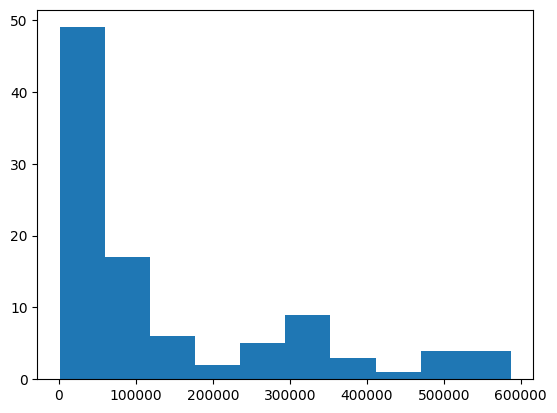

In [227]:
tmp = log_csv[log_csv['concept:name'] == ' First consult'].index + 1
mean_time = log_csv.loc[tmp,'relativetime_s'].mean() 
min_time = log_csv.loc[tmp,'relativetime_s'].min() 
max_time = log_csv.loc[tmp,'relativetime_s'].max() 
plt.hist(log_csv.loc[tmp,['relativetime_s']])

In [199]:
from pm4py.objects.petri_net.utils.performance_map import mean
import pm4py

first_to_next = pm4py.filter_event_attribute_values(log_csv, "NumOfAct", [2], level="event", retain=True, )

mean_time = mean(first_to_next['relativetime_s'])
mean_hour = mean_time // 3600
mean_minutes = (mean_time // 60) % 60

max_time = max(first_to_next['relativetime_s'])
max_hour = max_time // 3600
max_minutes = (max_time // 60) % 60

min_time = min(first_to_next['relativetime_s'])
min_hour = min_time // 3600
min_minutes = (min_time // 60) % 60

print(f"Среднее время между первой консультацией и следующей: {mean_hour} часов {mean_minutes} минут")
print(f"Максимальное время между первой консультацией и следующей: {max_hour} часов {max_minutes} минут")
print(f"Минимальное время между первой консультацией и следующей: {min_hour} часов {min_minutes} минут")

Среднее время между первой консультацией и следующей: 37.0 часов 7.0 минут
Максимальное время между первой консультацией и следующей: 163 часов 5 минут
Минимальное время между первой консультацией и следующей: 0 часов 22 минут


Text(0, 0.5, 'Пациенты')

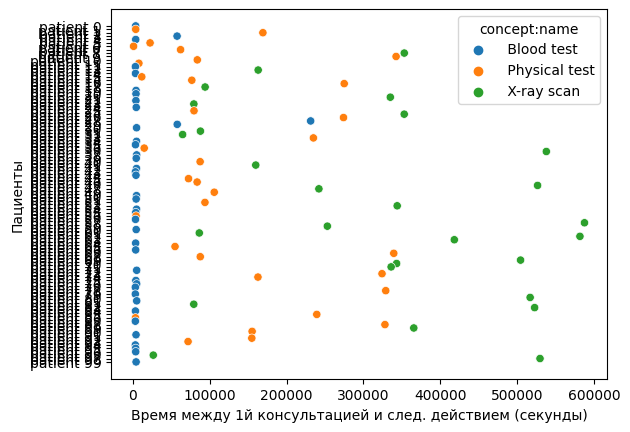

In [200]:
sns.scatterplot(x=first_to_next['relativetime_s'], y=first_to_next['case:concept:name'], hue=first_to_next['concept:name'])
plt.xlabel('Время между 1й консультацией и след. действием (секунды)')
plt.ylabel('Пациенты')

12. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.

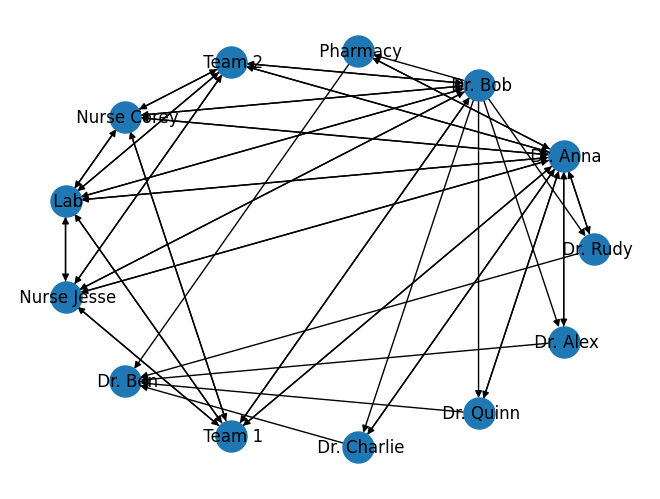

In [201]:
from pm4py import discover_handover_of_work_network, view_sna

net = discover_handover_of_work_network(log_csv)
view_sna(net, variant_str='networkx')
plt.show()

# **Задание 2**

#**Inductive**

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

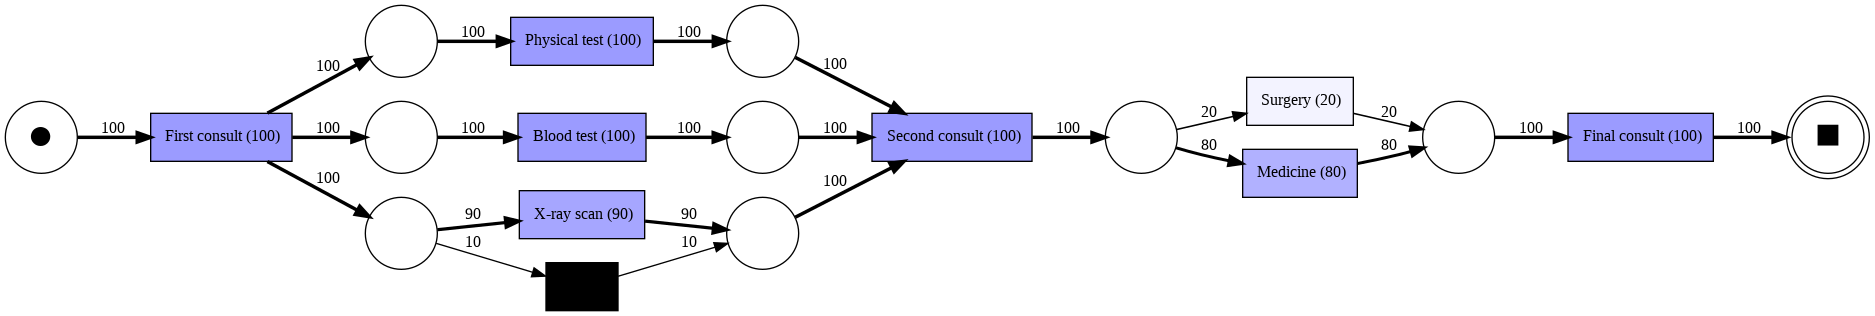

In [202]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
import pm4py
net, im, fm = pm4py.discover_petri_net_inductive(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [203]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

simplicity_ind = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_ind}\n")

Простота: 0.7599999999999999



In [204]:
fitness_ind = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_ind}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7999999999999985, 'log_fitness': 0.8, 'percentage_of_fitting_traces': 0.0}



In [205]:
prec_ind = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_ind}\n")

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 1.0



In [206]:
gen_ind = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_ind}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8603280868910275



#**Heuristics miner**

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

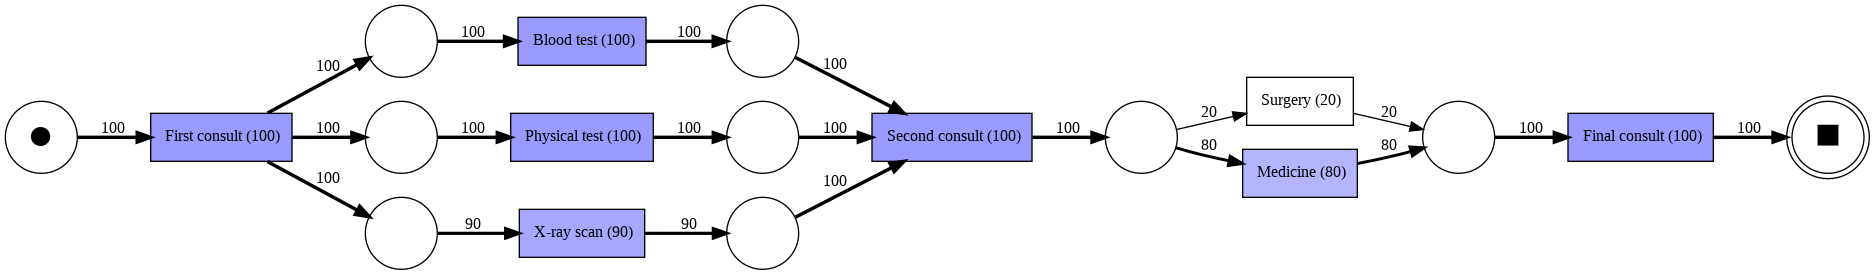

In [207]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

net, im, fm = heuristics_miner.apply(event_log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [208]:
simplicity_heu = simplicity_evaluator.apply(net)
print(f"Простота равна: {simplicity_heu}\n")

Простота равна: 0.8181818181818181



In [209]:
fitness_heu = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_heu}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7866666666666653, 'log_fitness': 0.7878787878787878, 'percentage_of_fitting_traces': 0.0}



In [210]:
prec_heu = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_heu}\n")

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 1.0



In [211]:
gen_heu = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_heu}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8823975685045107



# **Alpha**

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

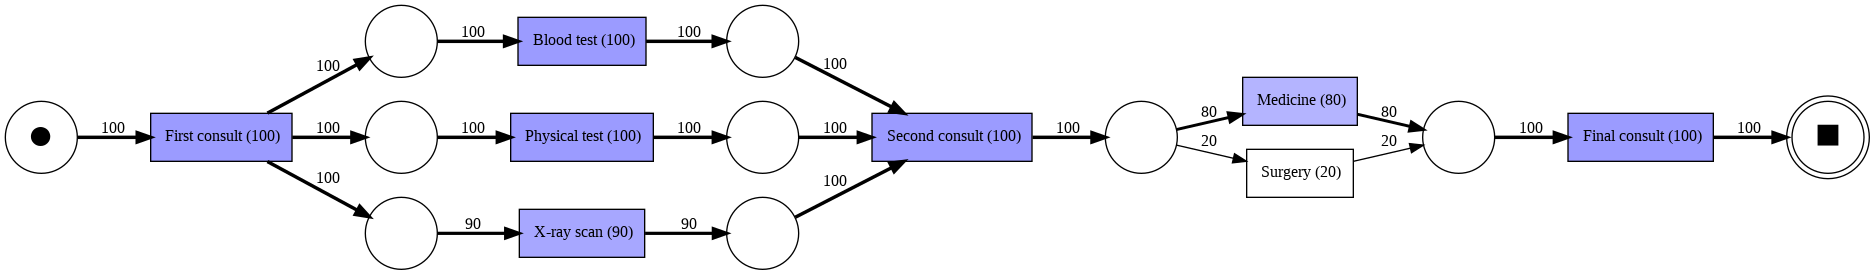

In [212]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

net, im, fm = alpha_miner.apply(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [213]:
simplicity_alp = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_alp}\n")

Простота: 0.8181818181818181



In [214]:
fitness_alp = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_alp}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7866666666666653, 'log_fitness': 0.7878787878787878, 'percentage_of_fitting_traces': 0.0}



In [215]:
prec_alp = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_alp}\n")

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 1.0



In [216]:
gen_alp = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_alp}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8823975685045107



# **DFG**

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

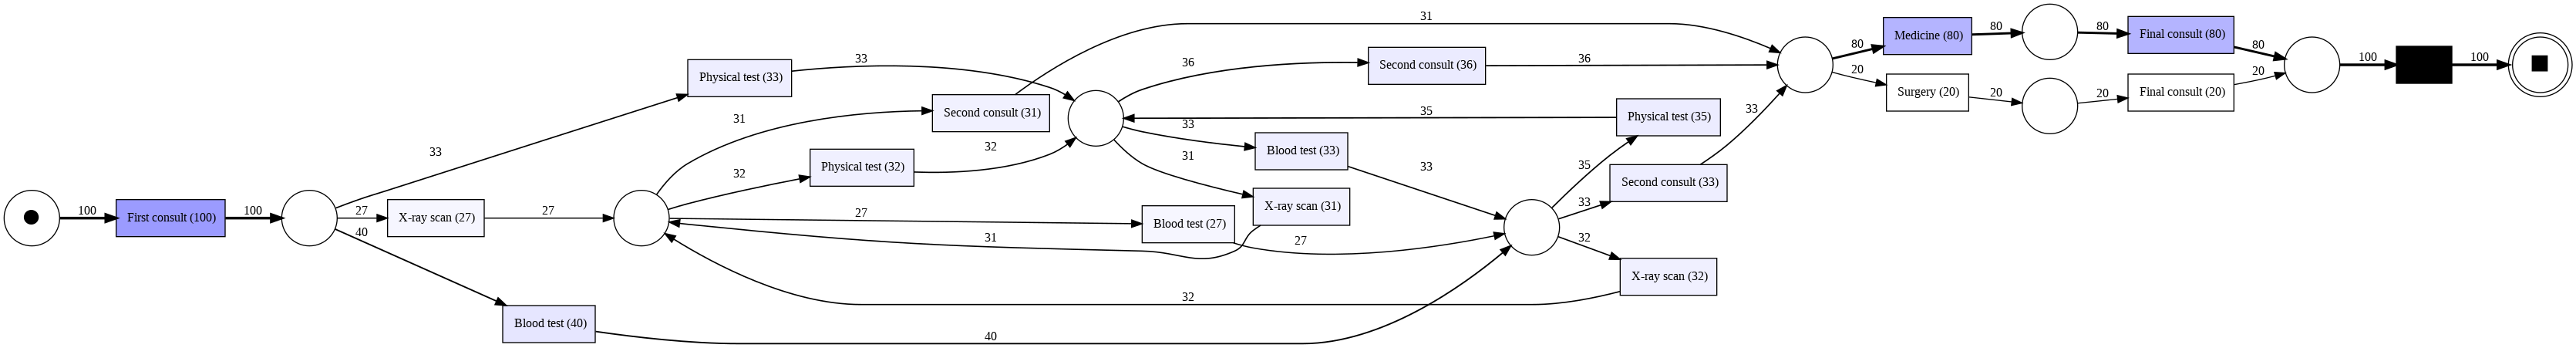

In [217]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(event_log)
from pm4py.objects.conversion.dfg import converter as dfg_mining
net, im, fm = dfg_mining.apply(dfg)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [218]:
simplicity_dfg = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_dfg}\n")

Простота: 0.6363636363636362



In [219]:
fitness_dfg = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_dfg}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7464285714285716, 'log_fitness': 0.7468354430379747, 'percentage_of_fitting_traces': 0.0}



In [220]:
prec_dfg = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_dfg}\n")

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 1.0



In [221]:
gen_dfg = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_dfg}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.7841928368975337



#**Сводная таблица**

In [234]:
from tabulate import tabulate

simpl = [["inductive miner", simplicity_ind], ["heuristics miner", simplicity_heu], ["alpha miner", simplicity_alp], ["DFG", simplicity_dfg]]
head1 = ["Алгоритм", "Простота"]
print(tabulate(simpl, headers=head1, tablefmt="grid"))
prec = [["inductive miner", prec_ind], ["heuristics miner", prec_heu], ["alpha miner", prec_alp], ["DFG", prec_dfg]]
head3 = ["Алгоритм", "Точность"]
print(tabulate(prec, headers=head3, tablefmt="grid"))
mydata = [["inductive miner", gen_ind], ["heuristics miner", gen_heu], ["alpha miner", gen_alp], ["DFG", gen_dfg]]
dat = [["inductive miner", fitness_ind['average_trace_fitness']], ["heuristics miner", fitness_heu['average_trace_fitness']], ["alpha miner", fitness_alp['average_trace_fitness']], ["DFG", fitness_dfg['average_trace_fitness']]]
head2 = ["Алгоритм", "Пригодность"]
print(tabulate(dat, headers=head2, tablefmt="grid"))
head4 = ["Алгоритм", "Обобщенность"]
print(tabulate(mydata, headers=head4, tablefmt="grid"))

+------------------+------------+
| Алгоритм         |   Простота |
+==================+============+
| inductive miner  |   0.76     |
+------------------+------------+
| heuristics miner |   0.818182 |
+------------------+------------+
| alpha miner      |   0.818182 |
+------------------+------------+
| DFG              |   0.636364 |
+------------------+------------+
+------------------+------------+
| Алгоритм         |   Точность |
+==================+============+
| inductive miner  |          1 |
+------------------+------------+
| heuristics miner |          1 |
+------------------+------------+
| alpha miner      |          1 |
+------------------+------------+
| DFG              |          1 |
+------------------+------------+
+------------------+---------------+
| Алгоритм         |   Пригодность |
+==================+===============+
| inductive miner  |      0.8      |
+------------------+---------------+
| heuristics miner |      0.786667 |
+------------------+----------


У моделей inductive miner, heuristics miner и alpha miner показатели очень схожи, что не даёт конкретного ответа: Какой метод лучше?

Самым отстоющим методом является GFG